This notebook shows how to apply **modification** functions to an **SDF** field and calculate the **gradient** of the **SDF** field with respect to the **parameters** of the **modification**, or the **SDF** function.

# IMPORTS

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import plotly.graph_objects as go
from plotly.subplots import make_subplots

from jax import jvp, jacfwd
import jax.numpy as jnp
from jax.scipy.spatial.transform import Rotation

from spomso.cores.helper_functions import generate_grid, smarter_reshape
from spomso.jax_cores.sdf_2D_jax import sdf_circle

from spomso.jax_cores.modifications_jax import onion, mirror, gaussian_falloff
from spomso.jax_cores.transformations_jax import compound_euclidian_transform_sdf
from spomso.jax_cores.post_processing_jax import gaussian_falloff_jax

# PARAMETERS

In [2]:
# size of the volume
co_size = 8, 8
# resolution of the volume
co_resolution = 400, 400

# FIELD, PROJECTED
show = "FIELD"
show_midplane = True
show_3d = True

# COORDINATE SYSTEM

Point cloud of coordinates is created with the **generate_grid** function, which takes the size of the coordinate system and the number of points in each direction (**co_resolution**).

In [3]:
coor, co_res_new = generate_grid(co_size, co_resolution)

If there is an even number of points along any direction the function will automatically convert it to an odd number, therefore the origin is always included in the point cloud. The point cloud is a **numpy.ndarray** with a shape of **(D, N)**, where **D** is the number of dimensions and **N** is the number of data points.

# CREATE SDFs

Define the radius of a **circles**, the **distance** between the **circles**, and the **width** of the **circles**:

In [4]:
radius = 1.
distance = 4.
width = 0.2

Define a new **SDF** where the **radius**, **distance**, and **width** are the parameters:

In [5]:
def transformed_circle(r, d, w):
    sdf = sdf_circle
    onioned_circle = onion(sdf, w)
    f_main = mirror(onioned_circle, [-d/2, 0, 0], [d/2, 0, 0])

    vec = jnp.asarray([0, 0, 0])
    rot_mat = Rotation.from_euler('z', 45, degrees=True).as_matrix()
    scale = 1.
    f_euclidean = compound_euclidian_transform_sdf(f_main, rot_mat, vec, scale)

    out = f_euclidean(coor, r)
    return out


## EVALUATE

Evaluate the **SDF** of the **geometry** to create a signed distance field 2D map.

In [6]:
final_pattern = transformed_circle(radius, distance, width)

Calculate the **Jacobian** with respect to the **radius** (argnums=0), **distance** (argnums=1), or **width** (argnums=2) parameters:

In [7]:
gradient_pattern = jacfwd(transformed_circle, argnums=1)(radius, distance, width)

Convert the final pattern and the gradient pattern into a 2D image:

In [8]:
field = smarter_reshape(final_pattern, co_resolution)
gradient_field = smarter_reshape(gradient_pattern, co_resolution)

# PROJECTION

**Project** the **SDF** to another scalar field using a **post-processing** function:

In [9]:
if show == "PROJECTED":
    gf, grad_gf = jvp(gaussian_falloff_jax, (final_pattern, 1.0, 0.5), (gradient_pattern, 0., 0.))
    field, gradient_field = smarter_reshape(gf, co_resolution), smarter_reshape(grad_gf, co_resolution)

# PLOT

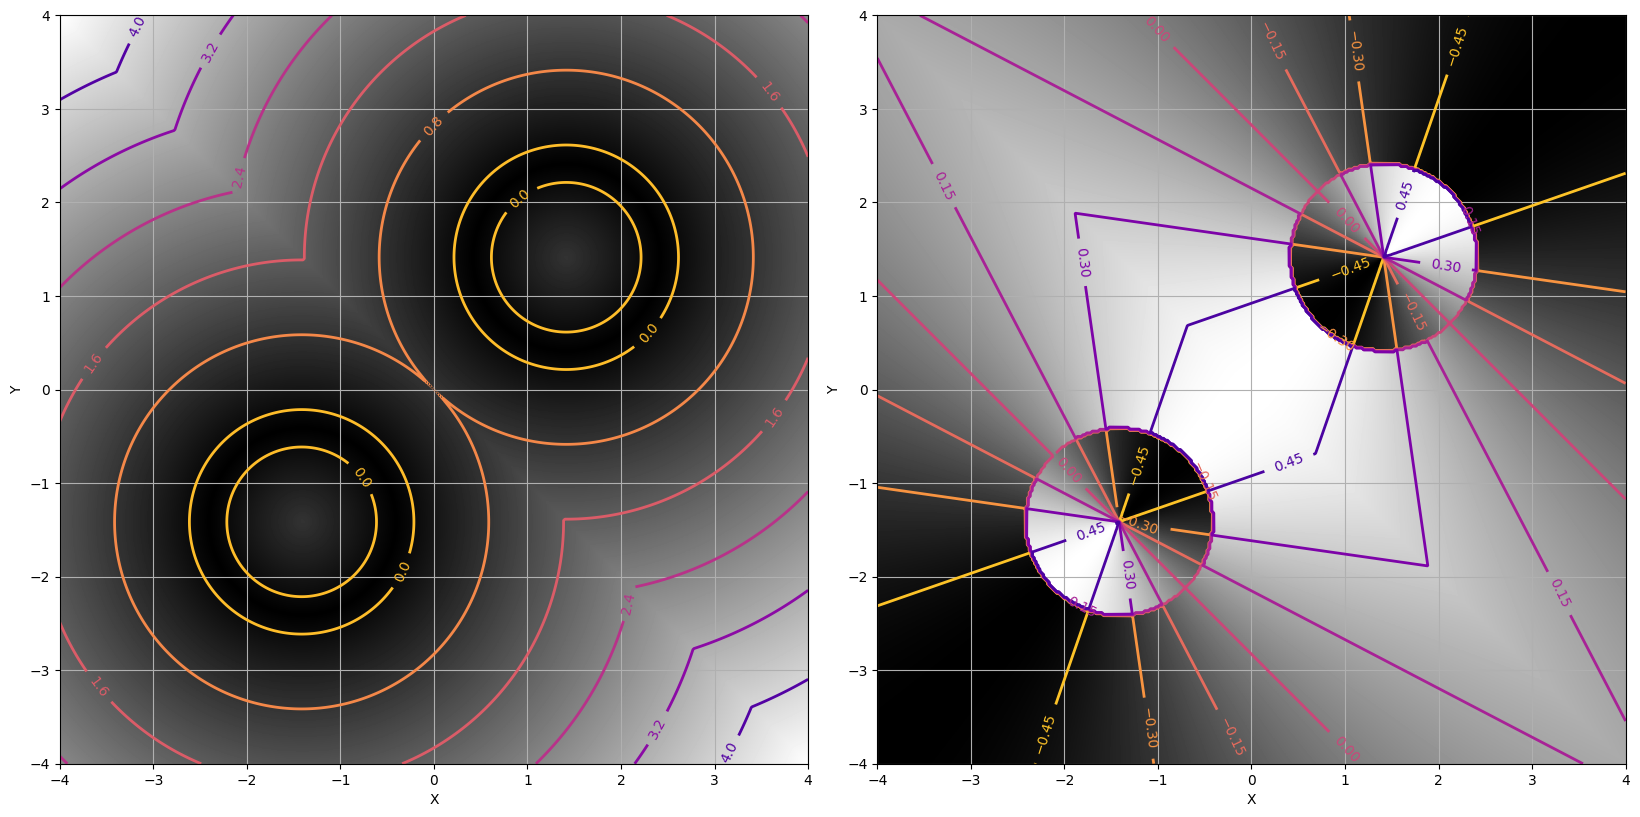

In [10]:
if show_midplane:
    fig, axs = plt.subplots(1, 2, figsize=(2*8.25, 8.25))

    # FIELD
    axs[0].imshow(field[:, :].T,
              cmap="binary_r",
              extent=(-co_size[0] / 2, co_size[0] / 2,
                      -co_size[1] / 2, co_size[1] / 2),
              origin="lower"
              )
    cs1 = axs[0].contour(coor[0].reshape(co_res_new[0], co_res_new[1]),
                    coor[1].reshape(co_res_new[0], co_res_new[1]),
                    field[:, :],
                    cmap="plasma_r",
                    linewidths=2)
    axs[0].clabel(cs1, inline=True, fontsize=10)
    axs[0].grid()

    # GRADIENT
    axs[1].imshow(gradient_field[:, :].T,
                  cmap="binary_r",
                  extent=(-co_size[0] / 2, co_size[0] / 2,
                          -co_size[1] / 2, co_size[1] / 2),
                  origin="lower"
                  )
    cs2 = axs[1].contour(coor[0].reshape(co_res_new[0], co_res_new[1]),
                        coor[1].reshape(co_res_new[0], co_res_new[1]),
                        gradient_field[:, :],
                        cmap="plasma_r",
                        linewidths=2)
    axs[1].clabel(cs2, inline=True, fontsize=10)
    axs[1].grid()
    
    for ax in axs:
        ax.set_xlabel("X")
        ax.set_ylabel("Y")

    fig.tight_layout()
    plt.show()

In [ ]:
if show_3d:
    patterns = ((field, gradient_field),)
    titles = ("Field", "Gradient")

    fig = make_subplots(rows=1, cols=2,
                        specs=[[{'is_3d': True}, {'is_3d': True}]],
                        subplot_titles=titles
                        )

    for i in range(1):
        for j in range(2):
            fig.add_trace(go.Surface(x=coor[0].reshape(co_res_new[0], co_res_new[1]),
                                     y=coor[1].reshape(co_res_new[0], co_res_new[1]),
                                     z=patterns[i][j][:, :],
                                     contours={
                                         "z": {"show": True,
                                               "start": np.floor(np.amin(patterns[i][j][:, :]*10))/10,
                                               "end": np.ceil(np.amax(patterns[i][j][:, :]*10))/10,
                                               "size": 0.1}
                                     },
                                     cmin=0,
                                     cmax=1),
                          1 + i, 1 + j,
                          )

            fig.update_traces(contours_z=dict(show=True, usecolormap=False,
                                              highlightcolor="limegreen", project_z=True))

    fig.show()